In [84]:
import pandas as pd
import numpy as np
import copy
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [85]:
data = pd.read_csv('amazon.csv')
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

In [86]:
# число значений у признаков
max_value = 0
for col_name in data.columns:
    max_value = max(max_value, np.max(data[col_name]))
print(max_value)

312153


In [87]:
def get_pair_features(X):
    print("Begin")
    X_new = np.ndarray((X.shape[0], X.shape[1] * (X.shape[1] + 1) // 2))
    X_new[:, 0:X.shape[1]] = copy.deepcopy(X.iloc[:])
    print("End copy")
    len = X.shape[1]
    for i in range(X.shape[1]):
        print("Processing", i, "features")
        for j in range(i + 1, X.shape[1]):
            X_new[:, len] = X.iloc[:, i] * 1000 * 1000 * 1000 + X.iloc[:, j] 
            len += 1
    return X_new

In [88]:
X_train_with_pair_features = get_pair_features(X_train)
X_test_with_pair_features = get_pair_features(X_test)

Begin
End copy
Processing 0 features
Processing 1 features
Processing 2 features
Processing 3 features
Processing 4 features
Processing 5 features
Processing 6 features
Processing 7 features
Processing 8 features
Begin
End copy
Processing 0 features
Processing 1 features
Processing 2 features
Processing 3 features
Processing 4 features
Processing 5 features
Processing 6 features
Processing 7 features
Processing 8 features


In [89]:
def unique_with_count(input_array): # (value, count)
    buf = copy.deepcopy(input_array)
    buf = buf[buf == buf]
    buf = np.sort(buf)
    
    Y = np.concatenate((buf[1:], np.array([np.nan])))
    lens_seg = np.cumsum(np.ones(buf.shape[0]))
    val = buf[buf != Y]
    lens_seg = lens_seg[buf != Y]
    lens_seg = np.asarray(np.concatenate((lens_seg[0:1], np.diff(lens_seg))), dtype = int)
    return (val, lens_seg)

In [90]:
def display_auc(y_true, y_predict):
    print("AUC:", sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true))
    (fpr, tpr, thresholds) = sklearn.metrics.roc_curve(y_true=y_true, y_score=y_predict)
    plt.plot(fpr, tpr)
    plt.show()

def get_auc(y_true, y_predict):
    return sklearn.metrics.roc_auc_score(y_score=y_predict, y_true=y_true)

In [91]:
def unique_with_count(input_array): # (value, count)
    buf = copy.deepcopy(input_array)
    buf = buf[buf == buf]
    buf = np.sort(buf)
    
    Y = np.concatenate((buf[1:], np.array([np.nan])))
    lens_seg = np.cumsum(np.ones(buf.shape[0]))
    val = buf[buf != Y]
    lens_seg = lens_seg[buf != Y]
    lens_seg = np.asarray(np.concatenate((lens_seg[0:1], np.diff(lens_seg))), dtype = int)
    return (val, lens_seg)

In [115]:
def get_new_features(X, count, successed):
    cnt = 0
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            new_X[i, 3 * j] = count[j].get(X[i, j], 0)
            new_X[i, 3 * j + 1] = successed[j].get(X[i, j], 0)
            new_X[i, 3 * j + 2] =  round((new_X[i, 3 * j + 1] + 1) / (new_X[i, 3 * j] + 2), 4)
            cnt += new_X[i, 3 * j] == 0;
    print(cnt)
    return new_X

def get_count_and_successed(X_train, y_train):
    count = [{} for i in range(X_train.shape[1])]
    successed = [{} for i in range(X_train.shape[1])]
    for col in range(X_train.shape[1]):
        value, len = unique_with_count(X_train[:, col])
        
        count[col] = {cur_value: 0 for cur_value in value}
        successed[col] = {cur_value: 0 for cur_value in value}
        for ind in range(X_train.shape[0]):
            count[col][X_train[ind, col]] += 1
            successed[col][X_train[ind, col]] += (y_train[ind] == 1)
        
        for cur_value in value:
            count[col][cur_value] /= y_train.shape[0]
            successed[col][cur_value] /= y_train.shape[0]
            successed[col][cur_value] = successed[col][cur_value]
    return (count, successed)

In [116]:
def get_new_features_with_fold(X, y, CNT_FOLDS = 3):
    new_X = np.ndarray((X.shape[0], 3 * X.shape[1]))
    for i in range(CNT_FOLDS):
        ind = np.ndarray(((X.shape[0] + CNT_FOLDS - 1 - i) // CNT_FOLDS), dtype=int)
        other_ind = np.ndarray(X.shape[0] - ind.shape[0], dtype=int)
        cnt = 0
        cnt_other = 0
        for j in range(X.shape[0]):
            if (j % CNT_FOLDS == i):
                ind[cnt] = j
                cnt += 1
            else:
                other_ind[cnt_other] = j
                cnt_other += 1

        count, successed = get_count_and_successed(X[other_ind, :], y[other_ind])
        X_chunk_new = get_new_features(X[ind, :], count, successed)
        new_X[ind, :] = X_chunk_new
    return new_X


In [117]:
CNT_FOLDS = 3
new_X_train_with_pair_features = get_new_features_with_fold(X_train_with_pair_features, np.array(y_train, dtype=int), CNT_FOLDS)
count, successed = get_count_and_successed(X_train_with_pair_features, np.array(y_train, dtype=int))
new_X_test_with_pair_features = get_new_features(X_test_with_pair_features, count, successed)

45652
45588
46022
47673


AUC: 0.847844202625


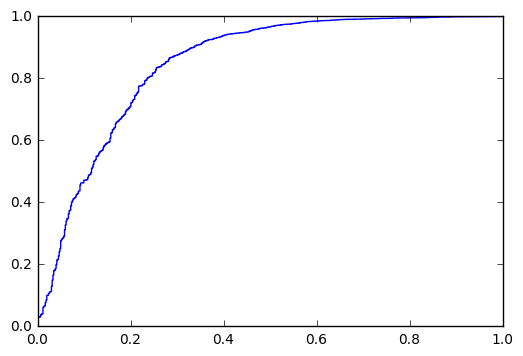

In [118]:
classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, max_depth=20, min_samples_leaf=15)
classifier.fit(new_X_train_with_pair_features, y_train)
y = classifier.predict_proba(new_X_test_with_pair_features)
y = y[:, 1]
display_auc(y_true=y_test, y_predict=y)